In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [2]:
from __future__ import print_function
import numpy as np
import pandas as pd
import sys
import os
import io
import tensorflow as tf
print(tf.__version__)
import codecs
from keras.callbacks import LambdaCallback, ModelCheckpoint, EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, LSTM, Bidirectional, Embedding
from keras.models import load_model
from tensorflow.keras.utils import plot_model

2.4.1


In [3]:
sequence_length=10
min_word_frequency=10
step=1
batch_size=200

**Shuffle and split training set**

In [4]:
def shuffle_and_split_training_set(sentences_original, next_original, percentage_test=2):
  print("Shuffling sentences...")
  tmp_sentences=[]
  tmp_next_word=[]
  for i in np.random.permutation(len(sentences_original)):
    tmp_sentences.append(sentences_original[i])
    tmp_next_word.append(next_original[i])
  cut_index=int((1-((percentage_test)/100.0))*len(sentences_original))
  x_train, x_test=tmp_sentences[:cut_index], tmp_sentences[cut_index:]
  y_train, y_test=tmp_next_word[:cut_index], tmp_next_word[cut_index:]
  print("Size of training set=", len(x_train))
  print("Size of test set=", len(y_test))
  return (x_train, x_test), (y_train, y_test)

**Generator function**

In [5]:
def generator(sentence_list, next_word_list, batch_size):
  index=0
  while True:
    x=np.zeros((batch_size, sequence_length), dtype=np.int32)
    y=np.zeros((batch_size), dtype=np.int32)
    for i in range(batch_size):
      for t, w in enumerate(sentence_list[index%len(sentence_list)]):
        x[i, t]=word_indices[w]
      y[i]=word_indices[next_word_list[index%len(sentence_list)]]
      index+=1                                             
    yield x, y

**Write generated vocabulary to a file**

In [6]:
def print_vocabulary(words_file_path, words_set):
  words_file=codecs.open(words_file_path, 'w', encoding='utf8')
  for w in words_set:
    if (w!='\n'):
      words_file.write(w+"\n")
    else:
      words_file.write(w)
  words_file.close()

**Build an LSTM Model**

In [7]:
def get_model():
    print('Build model...')
    model=tf.keras.Sequential()
    model.add(Embedding(input_dim=len(words), output_dim=1024))
    model.add(Bidirectional(LSTM(256, return_sequences=True)))
    model.add(Bidirectional(LSTM(256, return_sequences=True)))
    model.add(Bidirectional(LSTM(512, return_sequences=True)))
    model.add(Bidirectional(LSTM(1024)))
    model.add(Dense(len(words), activation='tanh'))
    model.add(Dense(len(words)))
    model.add(Activation('softmax'))
    print("Done!")
    return model

In [8]:
def sample(preds, temperature=1.0):
  preds=np.asarray(preds).astype('float64')
  preds=np.log(preds)/temperature
  exp_preds=np.exp(preds)
  preds=exp_preds/sum(exp_preds)
  probas=np.random.multinomial(1, preds, 1)
  return np.argmax(probas)

**Behavior at the end of an epoch**

In [9]:
def on_epoch_end(epoch, logs):
  examples_file.write("\n---Generating text after epoch %d\n"%epoch)
  seed_index=np.random.randint(len(sentences_train+sentences_test))
  seed=(sentences_train+sentences_test)[seed_index]
  diversity_array=np.arange(0.3, 0.8, 0.1)
  for diversity in diversity_array:
    sentence=seed
    diversity_string="\n---Diversity=%s.\n"%str(diversity)
    joined=' '.join(sentence)
    seed_sentence="\n---Seed sentence:%s.\n"%joined
    examples_file.write(diversity_string)
    examples_file.write(seed_sentence)
    examples_file.write(joined)
    examples_file.write('\n')
    for i in range(50):
      x_pred=np.zeros((1, sequence_length))
      for t, word in enumerate(sentence):
        x_pred[0, t]= word_indices[word]
      ##print("Generating predictions...")
      preds=model.predict(x_pred, verbose=0)[0]
      #print("Done!")
      #print("Generating next index...")
      next_index=sample(preds, diversity)
      #print("Done!")
      #print("Generating next word...")
      next_word=indices_word[next_index]
      #print("Done!")
      #print("Updating sentence value...")
      sentence=sentence[1:]
      #print("Done!")
      #print("Appending to sentence...")
      sentence.append(next_word)
      #print("Done!!!!!!!!!")
    examples_file.write(" "+next_word)
  examples_file.write("\n")
  examples_file.flush()

**Steve Erikson**

In [10]:
corpus='/content/gdrive/MyDrive/Project folder/Author text files/Steven Erikson.txt'
examples='/content/gdrive/MyDrive/Project folder/Authorwise examples/examples_steve_erikson.txt'
vocabulary='/content/gdrive/MyDrive/Project folder/Authorwise vocabulary/vocabulary_steve_erikson.txt'

In [11]:
if not os.path.isdir('/content/gdrive/MyDrive/Project folder/Authorwise text generation/Steve Erikson/checkpoints'):
  os.makedirs('/content/gdrive/MyDrive/Project folder/Authorwise text generation/Steve Erikson/checkpoints')

In [12]:
#with io.open(corpus, encoding='utf-8') as file:
file=open(corpus, encoding='utf8')
text=file.read().lower().replace('\n', '\n ')
print('Corpus length in characters=', len(text))

Corpus length in characters= 12836413


In [13]:
text_in_words=[w for w in text.split(' ') if w.strip()!='' or w=='\n']
print("Corpus length in words=", len(text_in_words))

Corpus length in words= 2280638


In [14]:
word_freq={}
for word in text_in_words:
  word_freq[word]=1+word_freq.get(word, 0)

In [15]:
len(word_freq)

98042

In [16]:
ignored_words=set('\n')
for k, v in word_freq.items():
  if word_freq[k]<min_word_frequency:
    ignored_words.add(k)

In [17]:
words=set(text_in_words)
print("Unique words before ignoring:", len(words))
words=sorted(set(text_in_words)-ignored_words)
print("Unique words after ignoring:", len(words))
print_vocabulary(vocabulary, words)

Unique words before ignoring: 98042
Unique words after ignoring: 15846


In [18]:
word_indices=dict((c, i) for i, c in enumerate(words))
indices_word=dict((i, c) for i, c in enumerate(words))

In [19]:
sentences=[]
next_words=[]
ignored=0
print("Generating sequences...", end="")
for i in range(0, len(text_in_words)-sequence_length, step):
  if (len(set(text_in_words[i:i+sequence_length+1]).intersection(ignored_words))==0):
    sentences.append(text_in_words[i:i+sequence_length])
    next_words.append(text_in_words[i+sequence_length])
  else:
    ignored+=1
print("Done!")

Generating sequences...Done!


In [20]:
print("Total ignored sequences: ", ignored)
print("Remaning sentences: ", len(sentences))
print("Number of words: ", len(next_words))

Total ignored sequences:  1317759
Remaning sentences:  962869
Number of words:  962869


In [21]:
(sentences_train, sentences_test), (next_words_train, next_words_test)=shuffle_and_split_training_set(sentences, next_words)

Shuffling sentences...
Size of training set= 943611
Size of test set= 19258


In [22]:
model=get_model()

Build model...
Done!


In [23]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

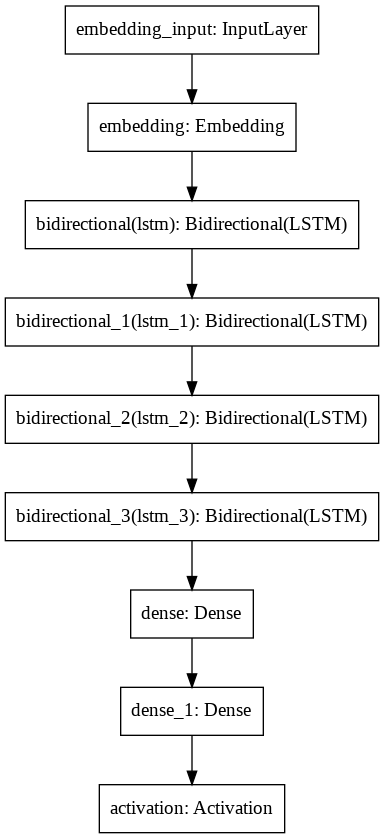

In [24]:
plot_model(model, to_file='Steven Erikson model.png')

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 1024)        16226304  
_________________________________________________________________
bidirectional (Bidirectional (None, None, 512)         2623488   
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 512)         1574912   
_________________________________________________________________
bidirectional_2 (Bidirection (None, None, 1024)        4198400   
_________________________________________________________________
bidirectional_3 (Bidirection (None, 2048)              16785408  
_________________________________________________________________
dense (Dense)                (None, 15846)             32468454  
_________________________________________________________________
dense_1 (Dense)              (None, 15846)             2

In [ ]:
examples_file=open(examples, "w")

In [ ]:
file_path = "//content/gdrive/MyDrive/Project folder/Authorwise text generation/Steve Erikson/checkpoints/METG-epoch{epoch:03d}-words%d-sequence%d-minfreq%d-" \
                "loss{loss:.4f}-accuracy{accuracy:.4f}-val_loss{val_loss:.4f}-val_accuracy{val_accuracy:.4f}" % \
                (len(words), sequence_length, min_word_frequency)

In [ ]:
checkpoint=ModelCheckpoint(file_path, monitor='val_accuracy', save_best_only=True)
print_callback=LambdaCallback(on_epoch_end=on_epoch_end)
early_stopping=EarlyStopping(monitor='val_accuracy', patience=2)
callbacks_list=[checkpoint, print_callback, early_stopping]

In [ ]:
int(len(sentences_test)/batch_size)+1

97

In [ ]:
with tf.device('/gpu:0'):
  history=model.fit_generator(generator(sentences_train, next_words_train, batch_size), 
                    steps_per_epoch=int(len(sentences_train)/batch_size)+1, 
                    epochs=10, 
                    callbacks=callbacks_list, 
                    validation_data=generator(sentences_test, next_words_test, batch_size), 
                    validation_steps=int(len(sentences_test)/batch_size)+1)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
4719/4719 [==============================] - 1833s 388ms/step - loss: 6.0454 - accuracy: 0.1242 - val_loss: 5.6478 - val_accuracy: 0.1489


INFO:tensorflow:Assets written to: //content/gdrive/MyDrive/Project folder/Authorwise text generation/Steve Erikson/checkpoints/METG-epoch001-words15846-sequence10-minfreq10-loss6.0454-accuracy0.1242-val_loss5.6478-val_accuracy0.1489/assets


INFO:tensorflow:Assets written to: //content/gdrive/MyDrive/Project folder/Authorwise text generation/Steve Erikson/checkpoints/METG-epoch001-words15846-sequence10-minfreq10-loss6.0454-accuracy0.1242-val_loss5.6478-val_accuracy0.1489/assets


Epoch 2/10
4719/4719 [==============================] - 1825s 387ms/step - loss: 5.3840 - accuracy: 0.1548 - val_loss: 5.4810 - val_accuracy: 0.1611


INFO:tensorflow:Assets written to: //content/gdrive/MyDrive/Project folder/Authorwise text generation/Steve Erikson/checkpoints/METG-epoch002-words15846-sequence10-minfreq10-loss5.3840-accuracy0.1548-val_loss5.4810-val_accuracy0.1611/assets


INFO:tensorflow:Assets written to: //content/gdrive/MyDrive/Project folder/Authorwise text generation/Steve Erikson/checkpoints/METG-epoch002-words15846-sequence10-minfreq10-loss5.3840-accuracy0.1548-val_loss5.4810-val_accuracy0.1611/assets


Epoch 3/10
4719/4719 [==============================] - 1833s 388ms/step - loss: 4.9291 - accuracy: 0.1741 - val_loss: 5.6001 - val_accuracy: 0.1627


INFO:tensorflow:Assets written to: //content/gdrive/MyDrive/Project folder/Authorwise text generation/Steve Erikson/checkpoints/METG-epoch003-words15846-sequence10-minfreq10-loss4.9291-accuracy0.1741-val_loss5.6001-val_accuracy0.1627/assets


INFO:tensorflow:Assets written to: //content/gdrive/MyDrive/Project folder/Authorwise text generation/Steve Erikson/checkpoints/METG-epoch003-words15846-sequence10-minfreq10-loss4.9291-accuracy0.1741-val_loss5.6001-val_accuracy0.1627/assets


Epoch 4/10
4719/4719 [==============================] - 1828s 387ms/step - loss: 4.5999 - accuracy: 0.1959 - val_loss: 5.8191 - val_accuracy: 0.1573
Epoch 5/10
4719/4719 [==============================] - 1826s 387ms/step - loss: 4.3078 - accuracy: 0.2229 - val_loss: 6.0700 - val_accuracy: 0.1520


In [ ]:
from keras.models import model_from_json
model_json=model.to_json()
with open("/content/gdrive/MyDrive/Project folder/Authorwise text generation/Steve Erikson/model_steve_erikson.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("/content/gdrive/MyDrive/Project folder/Authorwise text generation/Steve Erikson/model_steve_erikson.h5")
print("Saved model to disk!")

Saved model to disk!


In [ ]:
model_file="/content/gdrive/MyDrive/Project folder/Authorwise text generation/Steve Erikson/checkpoints/METG-epoch003-words15846-sequence10-minfreq10-loss4.9291-accuracy0.1741-val_loss5.6001-val_accuracy0.1627"
from keras.models import load_model
model=load_model(model_file)

In [ ]:
##model=get_model()
model.load_weights("/content/gdrive/MyDrive/Project folder/Authorwise text generation/Steve Erikson/model_steve_erikson.h5")

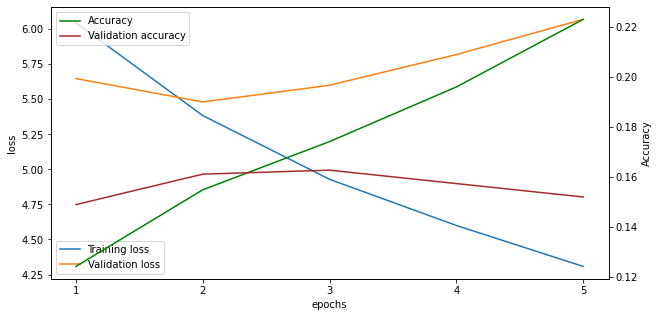

In [ ]:
import matplotlib.pyplot as plt
num_epochs=5

fig,(ax1)=plt.subplots(figsize=(10, 5))
ax2=ax1.twinx()

ax1.plot(range(1, num_epochs+1), history.history['loss'])
ax1.plot(range(1, num_epochs+1), history.history['val_loss'])

ax2.plot(range(1, num_epochs+1), history.history['accuracy'], color='green')
ax2.plot(range(1, num_epochs+1), history.history['val_accuracy'], color='brown')
plt.xticks(list(range(1, num_epochs+1)))

ax1.legend(['Training loss', 'Validation loss'])
ax2.legend(['Accuracy', 'Validation accuracy'])

ax1.set_xlabel('epochs')
ax1.set_ylabel('loss')
ax2.set_ylabel('Accuracy')

plt.show()

**Generate Text**

In [ ]:
def generate_text(model, indices_word, word_indices, 
                  seed, sequence_length, diversity, 
                  quantity, vocabulary, write_path, 
                  write_to_file=False, authorname=""):
  sentence=seed.split(" ")
  print("====Generating text====")
  print("Diversity: ", diversity)
  print("Seed sentence:",seed)
  counter=1
  full_appended_sentence=seed
  print(seed, end="")
  for i in range(quantity):
    x_pred=np.zeros((1, sequence_length))
    for t, word in enumerate(sentence):
      x_pred[0, t]= word_indices[word]
    ##print("Generating predictions...")
    preds=model.predict(x_pred, verbose=0)[0]
    next_index=sample(preds, diversity)
    next_word=indices_word[next_index]
    sentence=sentence[1:]
    sentence.append(next_word)
    print(" "+word, end="")
    full_appended_sentence=full_appended_sentence+" "+word
    if (counter%10==0):
      print("")
      full_appended_sentence=full_appended_sentence+"\n"
    counter+=1
  print("\n")
  if (write_to_file is True):
    filename=write_path+authorname+"_"+str(diversity)+"_"+str(quantity)+".txt"
    print("Writing to file...", end="")
    f=open(filename, "w")
    f.write(full_appended_sentence)
    print("Done!")
    f.close()

In [ ]:
##vocabulary_file="/content/gdrive/MyDrive/Project folder/Authorwise vocabulary/vocabulary_steve_erikson.txt"

In [ ]:
##model=load_model(model_file)
##vocabulary=open(vocabulary_file, "r").readlines()
##print(len(vocabulary))

In [ ]:
#import re
#vocabulary = sorted(set([re.sub(r'(\S+)\s+', r'\1', w) for w in vocabulary]))

In [ ]:
#word_indices=dict((c, i) for i, c in enumerate(words))
#indices_word=dict((i, c) for i, c in enumerate(words))

For generating essays with 250 words.

In [ ]:
seed_index=np.random.randint(len(sentences_train+sentences_test))
seed=(sentences_train+sentences_test)[seed_index]
seed=" ".join(seed)
print("==========================================")
print("Seed sentence:", seed)
print("==========================================")
diversity_array=np.arange(0.3, 1.1, 0.1)
for diversity in diversity_array:
  quantity=250
  generate_text(model, indices_word, word_indices, 
                seed, sequence_length, diversity, 
                quantity, words, 
                "/content/gdrive/MyDrive/Project folder/Author text generation/Steve Erikson/", 
                True, "Steve Erikson")
  print("=====================================================")

Seed sentence: bottle, gesler, stormy and balm as they set out after
====Generating text====
Diversity:  0.3
Seed sentence: bottle, gesler, stormy and balm as they set out after
bottle, gesler, stormy and balm as they set out after after the girl, the ones who refused to be in
 the first places. the king was gone. the first eunuch
 was standing on the wrong side of the throne, his
 eyes settling on the man. the thief stared at the
 shaft in the sky, then stepped back to the man.
 the bonecaster was gone. the one he was in the
 first places. the sound that erupted from the semk was
 a billowing cloud that churned into the sky, the sound
 that erupted in the air to make him leaving. the
 sound was the only one who had been thrown to
 the wrong places. the sound was a broad figure of
 wine. the sudden flash of the blood was in the
 air. the bonecaster was descending to the pitted horizon, and
 the sound of the blood churned down upon him. the
 sudden heat of the shattered shattered night.

For generating a small essay of 300 words.

In [ ]:
seed_index=np.random.randint(len(sentences_train+sentences_test))
seed=(sentences_train+sentences_test)[seed_index]
seed=" ".join(seed)
print("==========================================")
print("Seed sentence:", seed)
print("==========================================")
diversity_array=np.arange(0.3, 1.1, 0.1)
for diversity in diversity_array:
  quantity=300
  generate_text(model, indices_word, word_indices, 
                seed, sequence_length, diversity, 
                quantity, words, 
                "/content/gdrive/MyDrive/Project folder/Author text generation/Steve Erikson/", 
                True, "Steve Erikson")
  print("=====================================================")

Seed sentence: hands, and bit the guardsman in the face. the horse
====Generating text====
Diversity:  0.3
Seed sentence: hands, and bit the guardsman in the face. the horse
hands, and bit the guardsman in the face. the horse horse was gone. the priest had been dispatched the boy
 to voice the wrong name, it was a good thing
 he was the only one to get to the first
 throne, and then the one he stepped to one side
 and crouched down. the captain was gone. the two guards
 were gone. the captain was carrying a corpse on the
 steps and crouched down. the woman was thrown to the
 ground in the corridor and stepped to the sides, and
 then he was gone. the captain was gone. the nerek
 was gone. the nerek had been the only two days
 ago they had been in the first places. a veil
 of smoke was raining down to the sides, biting into
 the skull, the blood spraying in and out of the
 air. she was gone. the last of the jade strangers,
 the sun was marching to the west of the coast,
 the sun and the 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


 the wolves, but you were not the
 girl, girl, not in the first company. the nerek was
 not the only two soldiers to see the medium and
 medium cavalry were marching to one side the largest road,
 the largest of the growing fire. the mass of the
 shattered windows was in its centre. the two pardu shareholders
 stood on the other side of the hill, the one
 the one the past two – and the girl, her
 only father . i was a child of the fallen
 . but i am the milk and so the world
 is hidden and in the world to the very rebellion
 is now raining down to the earth and the crimson
 of windows crouched in a cloud of dust. the bonecaster
 had thrown him in the way of the wolves, the
 twin waves of smoke and smoke within the bright ache
 between the wounds within him, the promise of pain. the
 sudden yearning was cold with the veil of his eyes,
 the blood of the spirits on the ground was gone.
 the body was gone. the blood was engulfed in the
 sky, her body of the k'chain che'malle.' he studied t

For generating novels with 10000 words

In [ ]:
seed_index=np.random.randint(len(sentences_train+sentences_test))
seed=(sentences_train+sentences_test)[seed_index]
seed=" ".join(seed)
print("==========================================")
print("Seed sentence:", seed)
print("==========================================")
diversity_array=np.arange(0.3, 1.1, 0.1)
for diversity in diversity_array:
  quantity=10000
  generate_text(model, indices_word, word_indices, 
                seed, sequence_length, diversity, 
                quantity, words, 
                "/content/gdrive/MyDrive/Project folder/Author text generation/Steve Erikson/", 
                True, "Steve Erikson")
  print("=====================================================")

Seed sentence: the woman seated on the far left. she was mostly
====Generating text====
Diversity:  0.3
Seed sentence: the woman seated on the far left. she was mostly
the woman seated on the far left. she was mostly mostly gone. the captain was gone. the nerek had been
 born of the king and the others had been the
 only one who had been doing since the first one
 was to be the first to provide the priest to
 the king and the girl, and then, with a little
 words that was the kind of significance and the only
 good you'd know to be the girl, and you don't
 know what the adjunct said. but i was the one
 he was not to know what he had to do.
 the first message, then the bonecaster had halted and was
 gone. the corridor had deepened, no motion was a sickly
 figure, no more than a little more . the bonecaster
 was silent for a moment, and his eyes hardened on
 the man. 'we are the enemy. i am not the
 one in the first time, and the only one named
 the king had been dispatched to dev and lay

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


Streaming output truncated to the last 5000 lines.
 feet, and once that the body of the tiste edur
 and the hounds of shadow. the bonecaster was now in
 the first of... room in the giant tower. she was
 gone. he was already in the first places. the girl,
 a little faster … ‘ but this is a temple,
 you know. i am not the only one of the
 tiste andii's eyes on the motley seer, who now knelt
 beneath the cobbles, and the bonecaster was gone. the darkness
 was dark, stretched above her, the sound more closed, a
 mass of flies. the sudden light of the shattered light
 of the black milk and the night itself was a
 contrary suited to the isolation they crouched before the river
 of shadow was the bole, a offer to the god's
 presence before the current closed up by the empty sky,
 and all that power that was in the cold air
 was nothing but a damp hue to the ground. the
 sudden awakening of the empty man. and the sound that
 erupted in the air was something that refused to be
 the blood that w

For generating novels with 10500 words.

In [ ]:
seed_index=np.random.randint(len(sentences_train+sentences_test))
seed=(sentences_train+sentences_test)[seed_index]
seed=" ".join(seed)
print("==========================================")
print("Seed sentence:", seed)
print("==========================================")
diversity_array=np.arange(0.3, 1.1, 0.1)
for diversity in diversity_array:
  quantity=10500
  generate_text(model, indices_word, word_indices, seed, sequence_length, diversity, quantity, words, 
                "/content/gdrive/MyDrive/Project folder/Author text generation/Steve Erikson/", True, "Steve Erikson")
  print("=====================================================")

Seed sentence: shoulder slumped, its arm hanging useless. as gruntle backed still
====Generating text====
Diversity:  0.3
Seed sentence: shoulder slumped, its arm hanging useless. as gruntle backed still
shoulder slumped, its arm hanging useless. as gruntle backed still still more she was gone. the bonecaster was silent for
 a moment, and his eyes hardened on the boy, but
 i was the girl, the only good thing she has
 made to do is not for the significance of the
 betrayal that hunted the betrayal - and the only thing
 they now liked to do was the same for the
 rest of the way that was a fine man and
 a man was a good for a good thing. he
 was a good at one thing i was to do
 to use that . the only thing that was was
 the first to be done to the ruins. to the
 west coast, presumably, to the west of the empire. the
 ones who had been the ones who refused to fail.
 the world was a dark woman, a kind of reflected
 light. the sudden sound of the sudden flash of the
 air in the dark sky, the

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


Streaming output truncated to the last 5000 lines.
 a good warning to you, that was a good look,
 a good enough thing he was no good enough to
 get the way the only one ...' it was a
 strange sound to dust. 'like it?' the historian shook his
 head. 'we have the fallen to them now?’ the wraith
 clan was studying the side side by side. the historian
 stared at the man. but the presence of the king
 was in a dark light. the sound of the rearing
 medium from the wickans was a wolf. the ground was
 still in place, and the man was gone. a little
 more has been in a thousand paces from the wall
 on the other.' the man nodded. the bonecaster was silent
 a moment, then said, ‘in the case, the prince will
 make the truth of that – when the more as
 but a thing of blows. they had pressed up and
 that was the only one to find the one to
 come. the ones who do nothing but see how they
 know that they did not even die. they would miss
 the same of the two. sometimes they get to the
 edge of the kill